# Setup

In [ ]:
%pip install kornia==0.4.0
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
import pycocotools


## Mount drive

In [ ]:
your_path = ''
from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/'+your_path
import sys
sys.path.append(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Paths

In [ ]:
labels_path = path+ '/datasets/COCO/val2017_magiccoco_labels.csv'
weights_path = path+'/weights/super_coco_weights.pth' 

## GPU

In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  DEVICE = 'cpu'
  print('CUDA is not available.  Training on CPU ...')
else:
  DEVICE = 'cuda'
  print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data analysis

##Def transforms

In [ ]:
from torchvision import datasets, transforms
import PIL
import torch
from torch.utils.data import Dataset, DataLoader
import os
from skimage import io, transform
import numpy as np
import pandas as pd



class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        T = transforms.ToTensor()
        image = T(image)
        if not landmarks is 0:
          landmarks = torch.tensor(landmarks,dtype=torch.float32)
        return (image,landmarks)


class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        m = transforms.Resize((new_h, new_w), PIL.Image.BICUBIC)
        img = m(image)

        return (img,landmarks)




class ToGray(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample
        G = transforms.Grayscale(num_output_channels=1)
        if image.size()[0]>1:
          image = G(image)
        return (image,landmarks)


##Def dataset model

In [ ]:
from datasets.COCO.COCO_model import COCO_dataset


##Download data

###Coco

In [ ]:
'''import requests, zipfile, io
zip_url = "http://images.cocodataset.org/zips/val2017.zip"
r = requests.get(zip_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
new_path = path+'/datasets/COCO'
z.extractall(new_path)'''

BATCH_SIZE = 5

# Download the data
transform = transforms.Compose([ToTensor(),
                                Rescale((240,320)), 
                                ToGray()]) 


dataset = COCO_dataset(labels_path, path+'/datasets/COCO/val2017/', transform=transform, landmark_bool=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)
batch = next(iter(dataloader))

print(len(dataset))
print(len(dataloader))


86
18


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


##Help functions

In [ ]:
import matplotlib.pyplot as plt
import math
import kornia as K



def plot_imgs(imgs, label=None, titles=None, cmap='gray', ylabel='', normalize=False, ax=None, dpi=100):
    if not label is None:
      landmarks = np.asarray(label[:,0,:,:])
      landmarks = landmarks.astype('float')
    n = len(imgs)
    if not isinstance(cmap, list):
        cmap = [cmap]*n
    if ax is None:
        _, ax = plt.subplots(1, n, figsize=(6*n, 6), dpi=dpi)
        if n == 1:
            ax = [ax]
    else:
        if not isinstance(ax, list):
            ax = [ax]
        assert len(ax) == len(imgs)
    for i in range(n):
        if imgs[i].shape[-1] == 3:
            imgs[i] = imgs[i][..., ::-1]  # BGR to RGB
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmap[i]),
                     vmin=None if normalize else 0,
                     vmax=None if normalize else 1)
        if titles:
            ax[i].set_title(titles[i])
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if not label is None:
          ax[i].scatter(landmarks[i,:, 0][landmarks[i,:, 2]>0.015], landmarks[i,:, 1][landmarks[i,:, 2]>0.015], s=40, marker='.', c='r')
        
    ax[0].set_ylabel(ylabel)
    plt.tight_layout()


# Models

##Superpoint/Megicpoin model

###Main superpoint model

In [ ]:
from models.superpoint import SuperPointNet

superpoint_bool = True
eval_bool = True
model = SuperPointNet(superpoint_bool=superpoint_bool).to(DEVICE)
print(model)


SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

###Process probability map

In [ ]:
def get_prob_map(semi):
  m = torch.nn.Softmax(1)
  prob = m(semi)
  prob = prob[:, :-1, :, :]
  detector_output = torch.nn.functional.pixel_shuffle(prob, 8)
  return detector_output

###Get key point map

In [ ]:
def nms(prob, size, topk=None, thres=None):
  orig_shape = prob.size()
  pool = torch.nn.MaxPool2d(size,size, int(size/2), return_indices=True)
  unpool = torch.nn.MaxUnpool2d(size, size, int(size/2))
  folded_points, ind = pool(prob)
  points = unpool(folded_points, ind, orig_shape)

  if not topk is None:
    # Reshape and calculate positions of top 10%
    points = points.view(points.size(0), points.size(1), -1)
    nb_pixels = points.size(2)
    ret = torch.topk(points, k=topk, dim=2)
    ret.indices.shape

    # Scatter to zero'd tensor
    res = torch.zeros_like(points)
    res.scatter_(2, ret.indices, ret.values)
    points = res.view(orig_shape)
  if not thres is None:
    points[points<thres] = 0
  return points


###Process descriptors

In [ ]:
def get_descriptors(desc):
  interp = transforms.Resize((desc.size()[2]*8,desc.size()[3]*8), PIL.Image.BICUBIC)
  desc_full_size = interp(desc)
  dn = torch.norm(desc_full_size, p=2, dim=1) # Compute the norm.
  descriptor_output = desc_full_size.div(torch.unsqueeze(dn, 1)) # Divide by norm to normalize.
  return descriptor_output

##Load pretrained model

In [ ]:
model.load_state_dict(torch.load(weights_path,
                               map_location=lambda storage, loc: storage))
model.eval()


SuperPointNet(
  (relu): ReLU(inplace=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1a): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2a): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2b): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3a): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4a): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4b): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convPb): Conv2d(256, 65, kernel_size=(1, 1), stride=(1, 1))
  (convDa): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (convDb): Conv2d

In [ ]:
def detector_loss(DESC, warped_DESC=0, H=0):
  desc = DESC.permute(0,2,3,1)
  B,Hc,Wc = tuple(desc.size())[:3]
  cords = torch.stack(torch.meshgrid(torch.range(0,Hc),torch.range(0,Wc)), dim=-1).type(torch.int32)
  cords = cords*8 + 4
  


##Test pretrained model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  after removing the cwd from sys.path.


(5, 1, 300, 3)


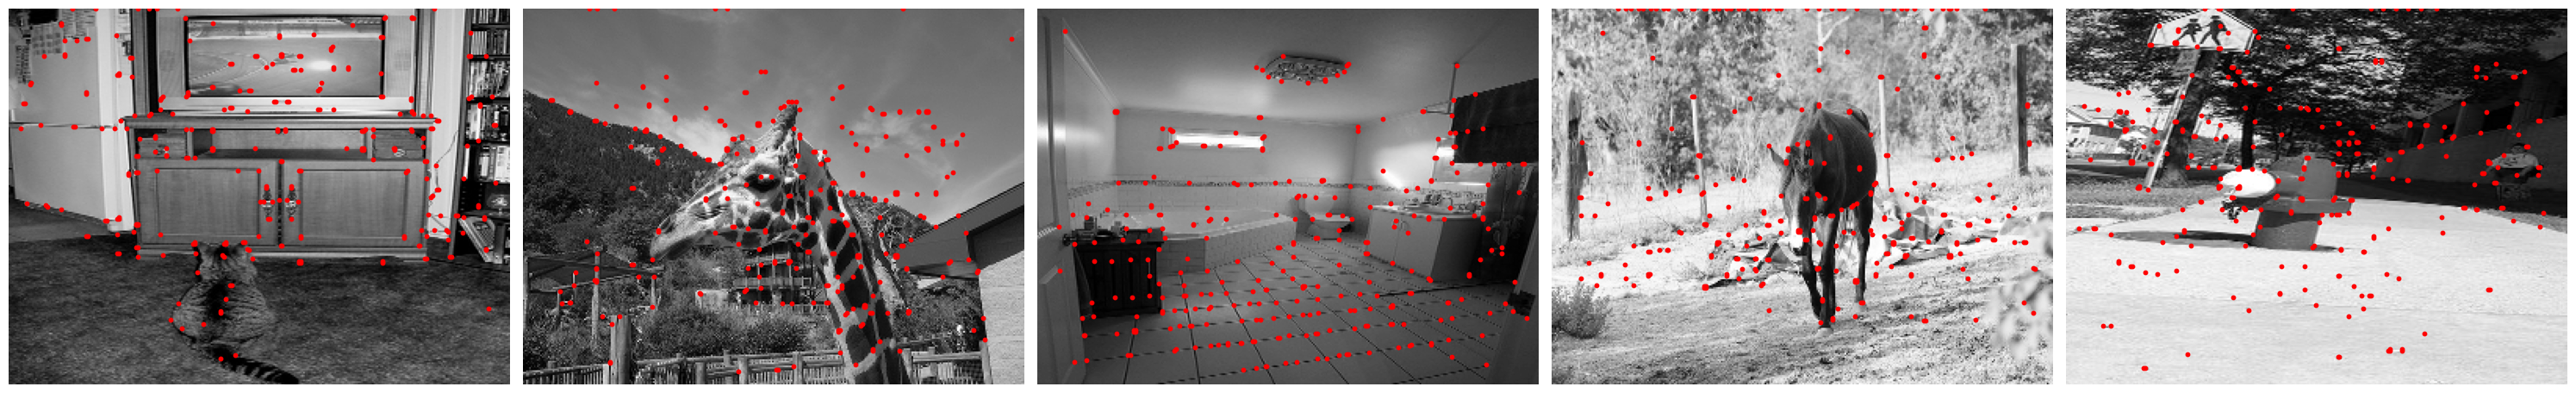

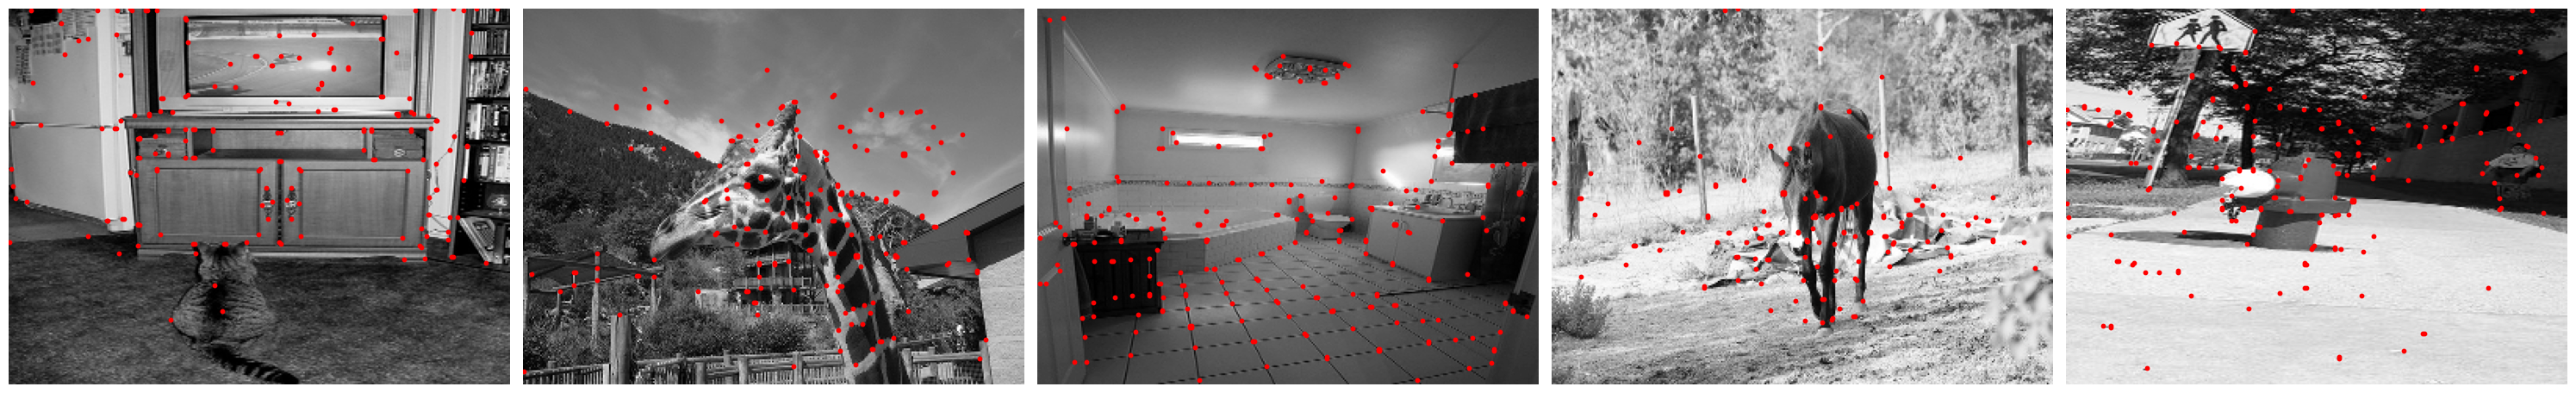

In [ ]:
im = batch[0].to(DEVICE)
B = im.size(0)
semi, desc = model.forward(im)
map = get_prob_map(semi)
detector_loss(desc)
points = nms(map, 4,300)
map_im = K.tensor_to_image(points)
orig_im = K.tensor_to_image(batch[0])

#plot as scatter
cords = np.where(map_im>0)
y = np.reshape(cords[1],(B,1,-1,1))
x = np.reshape(cords[2],(B,1,-1,1))
val = np.ones_like(x)
cords = np.concatenate((x,y,val),axis=3)
print(cords.shape)
plot_imgs(orig_im,label=cords)
labels = batch[1].unsqueeze(1)
plot_imgs(orig_im, labels)


